In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


In [ ]:
uploaded = files.upload()  # Upload 'content.jpg' and 'style.jpg'


Saving content.jpg to content (3).jpg
Saving style.jpg to style (1).jpg


In [ ]:
def load_image(path, max_size=400, shape=None):
    image = Image.open(path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)


In [ ]:
content = load_image("content.jpg")
style = load_image("style.jpg", shape=content.shape[-2:])


In [ ]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()


In [ ]:
for param in vgg.parameters():
    param.requires_grad = False


In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # content
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [ ]:
target = content.clone().requires_grad_(True).to(device)


In [ ]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.1
}

content_weight = 1e4  # alpha
style_weight = 1e2    # beta


In [ ]:
optimizer = optim.Adam([target], lr=0.003)


In [ ]:
steps = 500

for step in range(1, steps+1):
    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_weights:
        target_feat = target_features[layer]
        target_gram = gram_matrix(target_feat)
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feat.shape
        style_loss += layer_loss / (d * h * w)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Backprop
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print
    if step % 50 == 0:
        print(f"Step {step}/{steps}, Total Loss: {total_loss.item():.4f}")


Step 50/500, Total Loss: 15792.5107
Step 100/500, Total Loss: 10771.4326
Step 150/500, Total Loss: 8220.0469
Step 200/500, Total Loss: 6730.6064
Step 250/500, Total Loss: 5808.8066
Step 300/500, Total Loss: 5216.0742
Step 350/500, Total Loss: 4814.2056
Step 400/500, Total Loss: 4524.7485
Step 450/500, Total Loss: 4301.4102


In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze(0)
    image = image.permute(1, 2, 0)
    image = image * torch.tensor((0.229, 0.224, 0.225)) + torch.tensor((0.485, 0.456, 0.406))
    image = image.clamp(0, 1)
    return image


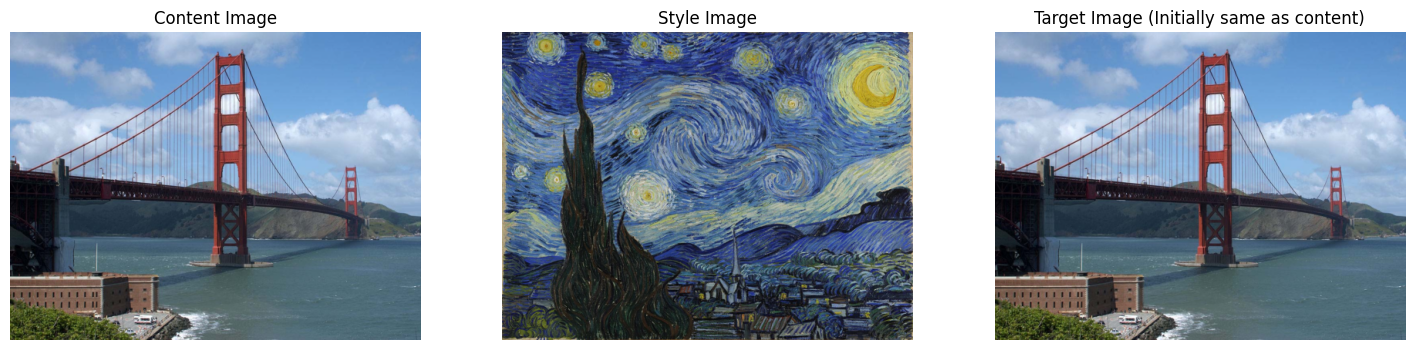

In [ ]:
# 1. Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# 2. Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Image loader
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max_size is not None:
        size = max(image.size)
        if size > max_size:
            size = max_size
        else:
            size = max(image.size)
    else:
        size = max(image.size)

    if shape is not None:
        size = shape  # shape should be a tuple like (400, 400)

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

# 4. Load images from your uploads
content = load_image("content.jpg").to(device)
style = load_image("style.jpg", shape=tuple(content.shape[-2:])).to(device)

# 5. Clone target
target = content.clone().requires_grad_(True).to(device)

# 6. Convert tensor to image for display
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

# 7. Display all three images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax1.axis("off")

ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
ax2.axis("off")

ax3.imshow(im_convert(target))
ax3.set_title("Target Image (Initially same as content)")
ax3.axis("off")

plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 70.4MB/s]


Step 100, Total loss: 2580222.5000
Step 200, Total loss: 1245260.2500
Step 300, Total loss: 690548.0000
Step 400, Total loss: 453908.7188
Step 500, Total loss: 339504.8125


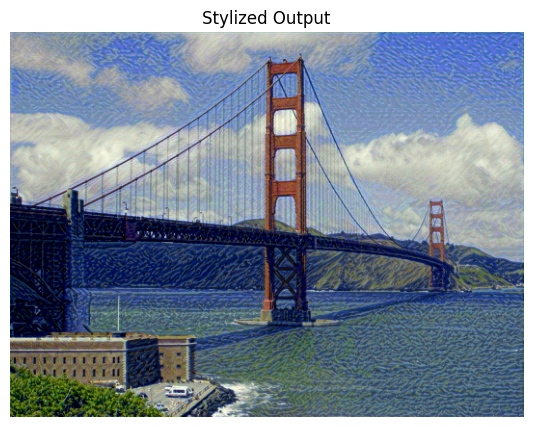

In [ ]:
# 8. Define VGG model and extract layers
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze all VGG parameters
for param in vgg.parameters():
    param.requires_grad = False

# Layers for style and content extraction
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# Helper to get correct layer index
def get_features(image, model, layers=None):
    features = {}
    x = image
    layer_mapping = {
        '0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1',
        '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'
    }

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layer_mapping:
            layer_name = layer_mapping[name]
            if layers is None or layer_name in layers:
                features[layer_name] = x
    return features

# Gram Matrix for style
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# 9. Get content and style features
content_features = get_features(content, vgg, content_layers)
style_features = get_features(style, vgg, style_layers)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 10. Define weights
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1e4  # alpha
style_weight = 1e2    # beta

# 11. Optimizer
optimizer = optim.Adam([target], lr=0.003)

# 12. Style transfer training loop
steps = 500  # can increase for better results

for step in range(1, steps + 1):
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feat = target_features[layer]
        target_gram = gram_matrix(target_feat)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (target_feat.shape[1]**2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, Total loss: {total_loss.item():.4f}")

# 13. Display final styled image
plt.figure(figsize=(10, 5))
plt.imshow(im_convert(target))
plt.title("Stylized Output")
plt.axis("off")
plt.show()
